The goal of this notebook is to conduct basic EDA along with preliminary analysis using RFM

# Exploration & cleaning

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. The dataset has around 541K rows and 8 columns:
- InvoiceNo: A unique number for each transaction
- StockCode: A unique number for each product.
- Description: product description 
- Quantity: Number of products purchased for each transaction
- InvoiceDate: Transaction's Timestamp
- UnitPrice: The price per unit 
- CustomerID: Unique ID for each customer
- Country: Country name

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import datetime as dt
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import squarify
from sklearn.cluster import KMeans

## Load and prepare the data


In [102]:
data_path = 'dataset/data.csv'
data = pd.read_csv(data_path, encoding='iso-8859-1')

In [23]:
original = pd.read_csv(data_path, encoding='iso-8859-1')

Print a sample of one customer's transactions

In [103]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [104]:
# Check if we have missing values
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format='%m/%d/%Y %H:%M')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the summary above we know that we have some missing values in Description and CustomerID     

In [105]:
#How many missin values?
df = pd.DataFrame(data.isnull().sum())
df[df[0] != 0]

,0
Description,1454
CustomerID,135080


Since we are intersted in segmenting the customers, we want to drop all rows where the customer is unknown 

In [106]:
data = data.dropna()

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


### Get key statistics of the dataset

In [107]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Understanding negative quanitiy

In [32]:
data[data['Quantity']<0].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Do all transactions with negative quantity has an invoice code starting with C?

First, find the Length of total negative qnt

In [33]:
len(data[data['Quantity']<0])

8905

In [108]:
def extract_prefix(x):
    return x[0]
def start_with_c(x):
    return extract_prefix(x) == 'C'

First, find the Length of all items starting with C

In [109]:
temp = data[data['InvoiceNo'].apply(start_with_c)]
len(temp)

8905

From above, we conclude that all negative qnt has a C prefix. Probably indicates cancelled items

In [110]:
total_trans = len(data)
cancelled_trans = len(data[data['Quantity']<0])
print("Total purchases items  {}".format(total_trans))
print("Total number of cancelled items is {}".format(cancelled_trans))
print("With a % of {:.2f}% from the total".format(cancelled_trans/total_trans*100))

Total purchases items  406829
Total number of cancelled items is 8905
With a % of 2.19% from the total


Remove rows where quantity has negative values

In [112]:
#Drop negative quantity
data = data[data['Quantity']>0]
data.shape
#Drop free items
data = data[data['UnitPrice']!=0]
codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
data = data[~data['StockCode'].isin(codes)]
#Drop any row with description of length less than 1 
data=data[data['Description'].apply(lambda x: len(str(x.strip()))>0)]

In [46]:
len(data)

396337

# How many orderes in total?

In [47]:
total_orderes= len(data.groupby(by=['InvoiceNo']))
print("The total orderes = {}".format(total_orderes) )

The total orderes = 18402


In [48]:
total_orderes= len(original.groupby(by=['InvoiceNo']))
print("The total orderes before removing missing and incomplete data = {}".format(total_orderes) )

The total orderes before removing missing and incomplete data = 25900


# How many customers?

In [49]:
#len(data['CustomerID'].value_counts())
total_customeres = len(data.groupby(by=['CustomerID']))
print("The total Customeres = {}".format(total_customeres) )

The total Customeres = 4334


## Add total amount

We need to calculate the total ammount spent on each item (per transaction), and then on each invoice (purchase). To do so, we will add a new calculated col named `"Total amount"` as `unit price * quantity`

In [50]:
data['TotalAmount'] = data.UnitPrice * data.Quantity

In [51]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Aggregate the total of each invoice 

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396337 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo      396337 non-null object
StockCode      396337 non-null object
Description    396337 non-null object
Quantity       396337 non-null int64
InvoiceDate    396337 non-null datetime64[ns]
UnitPrice      396337 non-null float64
CustomerID     396337 non-null float64
Country        396337 non-null object
TotalAmount    396337 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.2+ MB


In [53]:

data_inv_agg = data.groupby(['InvoiceNo'], as_index=False)\
.agg({'Quantity': 'sum', 'TotalAmount': 'sum', 'InvoiceDate': 'first', 'CustomerID': 'first', 'Country': 'first'})

#Transform the date into columns 
data_inv_agg['month'] = pd.DatetimeIndex(data_inv_agg['InvoiceDate']).month 
data_inv_agg['year'] =  pd.DatetimeIndex(data_inv_agg['InvoiceDate']).year

data_inv_agg['yearmonth'] = data_inv_agg['InvoiceDate'].apply(lambda x: (100*x.year) + x.month)

data_inv_agg['day'] = pd.DatetimeIndex(data_inv_agg['InvoiceDate']).day
data_inv_agg['hour'] = pd.DatetimeIndex(data_inv_agg['InvoiceDate']).hour
data_inv_agg['day_of_week'] = pd.DatetimeIndex(data_inv_agg['InvoiceDate']).dayofweek
#replace day of week with string
dic = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu",  4: "Fri", 5 : "Sat" , 6:"Sun"}
data_inv_agg.replace({"day_of_week": dic} , inplace=True)


In [54]:
data_inv_agg[data_inv_agg['CustomerID'] == 12478.0]

,InvoiceNo,Quantity,TotalAmount,InvoiceDate,CustomerID,Country,month,year,yearmonth,day,hour,day_of_week
18046,580752,233,545.99,2011-12-06 09:56:00,12478.0,Greece,12,2011,201112,6,9,Tue


## Aggregate the total spending, count of orderes for each customer

In [68]:
data_customers_agg = data_inv_agg.groupby(['CustomerID'], as_index=False)\
.agg({'Quantity': 'sum', 
      'TotalAmount': 'sum', 'InvoiceNo': 'count', 
      'Country': 'first', 
      'day_of_week': lambda x: x.value_counts().index[0] ,
      'day': lambda x: x.value_counts().index[0] ,
      'hour': lambda x: x.value_counts().index[0] ,
      'month': lambda x: x.value_counts().index[0] 
     })
#rename cols
data_customers_agg.rename(columns={'InvoiceNo': "Num_of_transactions",
                           'day_of_week': "most_day_of_week",
                           'day': "most_day_of_month",
                           'hour': "most_hour",
                           'month': "most_month"
                          },inplace=True)

# 1- Customers 

To discover who spent the most amount on purchaese, we need first to calculate the total ammount spent on each item (per transaction), and then on each invoice (purchase). To do so, we will add a new calculated col named `"Total amount"` as `unit price * quantity`

# Q1: Who place the highest number of orders?

Text(0,0.5,'Num_of_transactions')

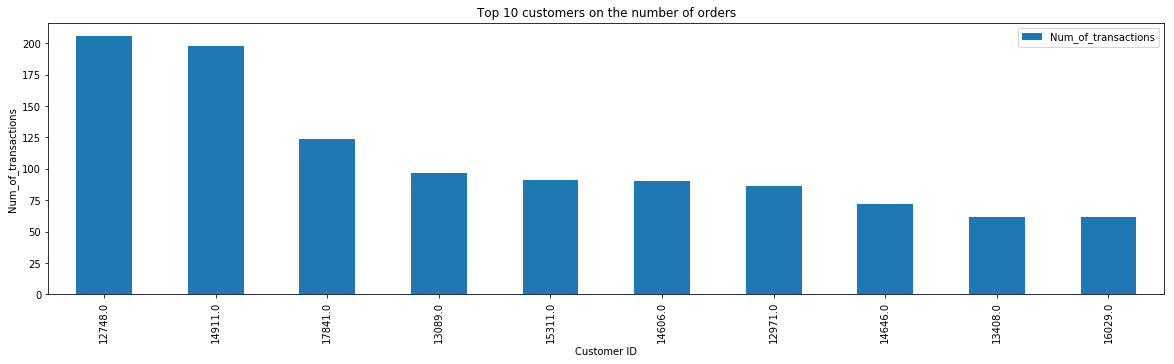

In [69]:
((data_customers_agg.sort_values(by=['Num_of_transactions'], ascending=False))[:10]).plot.bar(x='CustomerID', y='Num_of_transactions' ,figsize=(20,5))
plt.title("Top 10 customers on the number of orders")
plt.xlabel("Customer ID")
plt.ylabel("Num_of_transactions")

### a) How much did they actually spent?

In [70]:
df = data_customers_agg.sort_values(by=['Num_of_transactions'], ascending=False)[:10]
df[['CustomerID', 'TotalAmount']]

,CustomerID,TotalAmount
326,12748.0,32317.32
1879,14911.0,136275.72
4007,17841.0,40967.72
562,13089.0,58825.83
2176,15311.0,60767.90
1661,14606.0,12006.65
481,12971.0,11189.91
1689,14646.0,279138.02
795,13408.0,28117.04
2700,16029.0,72882.09


### B) What are thier fav day of week, month and hour ?

In [71]:
df = data_customers_agg.sort_values(by=['Num_of_transactions'], ascending=False)[:10]
print("The most freq day: {}".format(df['most_day_of_week'].value_counts().index[0]))
print("The most freq hour: {}".format(df['most_hour'].value_counts().index[0]))
print("The most freq month: {}".format(df['most_month'].value_counts().index[0]))

The most freq day: Wed
The most freq hour: 14
The most freq month: 12


# Q2: Who are the highest-spending customers?

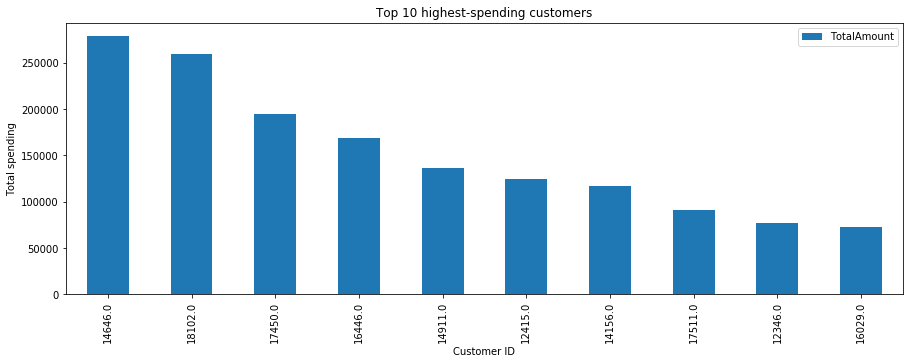

In [72]:
((data_customers_agg.sort_values(by=['TotalAmount'], ascending=False))[:10]).plot.bar(figsize=(15,5) , x='CustomerID', y='TotalAmount' )
plt.title("Top 10 highest-spending customers")
plt.xlabel("Customer ID")
plt.ylabel("Total spending")
plt.show()

### A) How many orderes did they actually place?


In [73]:
df = data_customers_agg.sort_values(by=['TotalAmount'], ascending=False)[:10]
df[['CustomerID', 'Num_of_transactions']]

,CustomerID,Num_of_transactions
1689,14646.0,72
4197,18102.0,60
3725,17450.0,46
3006,16446.0,2
1879,14911.0,198
55,12415.0,20
1333,14156.0,54
3768,17511.0,31
0,12346.0,1
2700,16029.0,62


### B) What are thier fav day of week, month and hour ?

In [74]:
df = data_customers_agg.sort_values(by=['TotalAmount'], ascending=False)[:10]
print("The most freq day: {}".format(df['most_day_of_week'].value_counts().index[0]))
print("The most freq hour: {}".format(df['most_hour'].value_counts().index[0]))
print("The most freq month: {}".format(df['most_month'].value_counts().index[0]))

The most freq day: Wed
The most freq hour: 11
The most freq month: 11


# Q3: Is there any overlap between the highest spending customers/ the customers with highest number of orderes?

In [75]:
top_spending_df = data_customers_agg.sort_values(by=['TotalAmount'], ascending=False)[:10]
most_orderes_df = data_customers_agg.sort_values(by=['Num_of_transactions'], ascending=False)[:10]
intersection_df = pd.merge(top_spending_df, most_orderes_df, how='inner', on=['CustomerID'])

In [76]:
print("There are {} customers".format(len(intersection_df)))
intersection_df[['CustomerID', 'TotalAmount_x', 'Num_of_transactions_x']]

There are 3 customers


,CustomerID,TotalAmount_x,Num_of_transactions_x
0,14646.0,279138.02,72
1,14911.0,136275.72,198
2,16029.0,72882.09,62


# Q4: Where did highest-spending customers come from?

In [77]:
df = (data_customers_agg.sort_values(by=['TotalAmount'], ascending=False))[:10]
df[['CustomerID', 'Country', 'TotalAmount']]

,CustomerID,Country,TotalAmount
1689,14646.0,Netherlands,279138.02
4197,18102.0,United Kingdom,259657.30
3725,17450.0,United Kingdom,194550.79
3006,16446.0,United Kingdom,168472.50
1879,14911.0,EIRE,136275.72
55,12415.0,Australia,124564.53
1333,14156.0,EIRE,116729.63
3768,17511.0,United Kingdom,91062.38
0,12346.0,United Kingdom,77183.60
2700,16029.0,United Kingdom,72882.09


As we can see from the table above, most of the highest-spending customers are from the UK. And the customer who spent the highest amount of money in his/her purchases is from Netherlands.

# 2- Number of orderes

# Q4: How many orders/transaction does the company has per month?

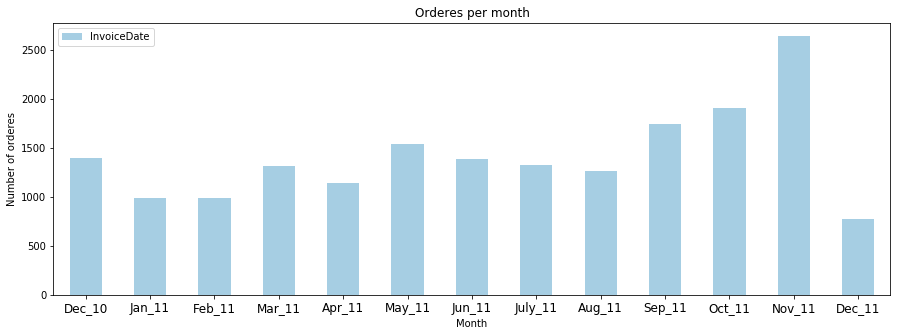

In [78]:
df = data_inv_agg.groupby(['yearmonth'], as_index=False)\
.agg({'InvoiceDate': 'count'})
ax = df.plot.bar(figsize=(15,5), x='yearmonth', y='InvoiceDate', colormap='Paired' )
plt.title("Orderes per month")
plt.xlabel("Month")
plt.ylabel("Number of orderes")
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=12)
plt.show()

# Q5: How many orders/transaction does the company has per day?

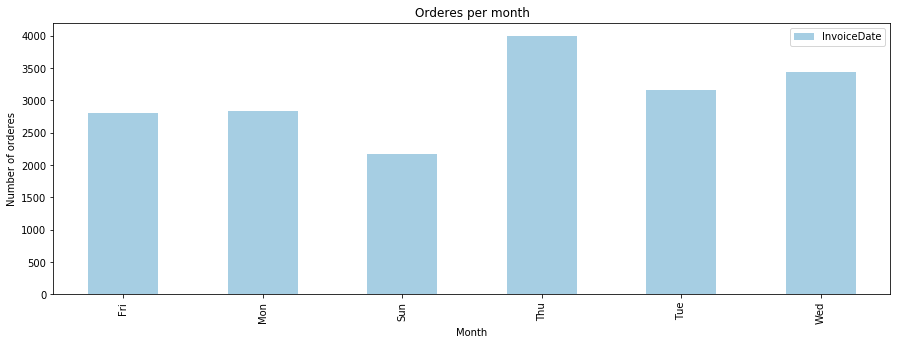

In [79]:
df = data_inv_agg.groupby(['day_of_week'], as_index=False)\
.agg({'InvoiceDate': 'count'})
ax = df.plot.bar(figsize=(15,5), x='day_of_week', y='InvoiceDate', colormap='Paired' )
plt.title("Orderes per month")
plt.xlabel("Month")
plt.ylabel("Number of orderes")
plt.show()

# Q6: How many orders/transaction does the company has per hour?

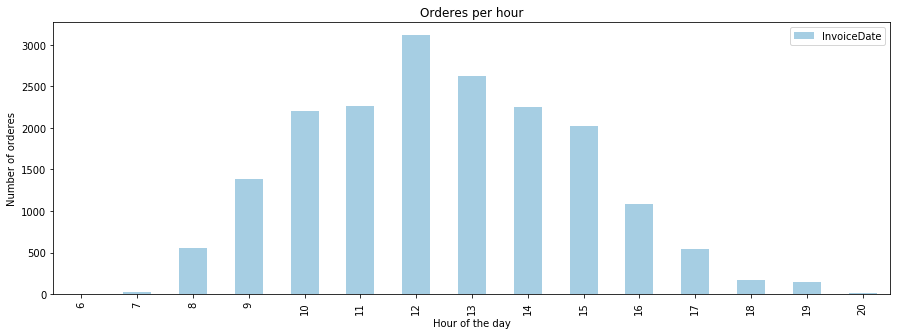

In [80]:
df = data_inv_agg.groupby(['hour'], as_index=False)\
.agg({'InvoiceDate': 'count'})
ax = df.plot.bar(figsize=(15,5), x='hour', y='InvoiceDate', colormap='Paired' )
plt.title("Orderes per hour")
plt.xlabel("Hour of the day")
plt.ylabel("Number of orderes")
plt.show()

# 3- Revenue

# Q6: How much revenue per month does the company earn?


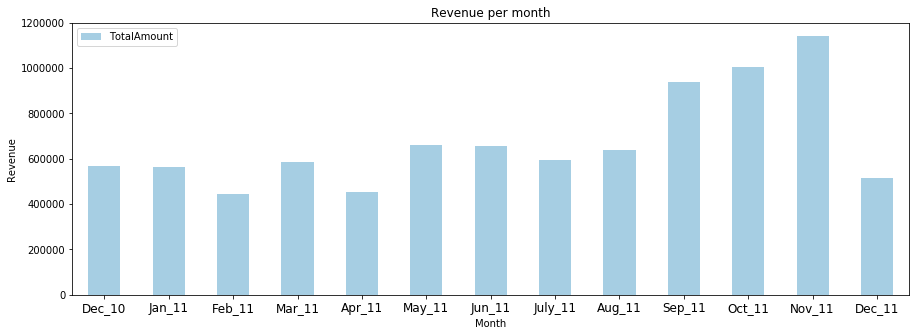

In [81]:
df = data_inv_agg.groupby(['yearmonth'], as_index=False)\
.agg({'TotalAmount': 'sum'})
ax = df.plot.bar(figsize=(15,5), x='yearmonth', y='TotalAmount', colormap='Paired' )
plt.title("Revenue per month")
plt.xlabel("Month")
plt.ylabel("Revenue")
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=12)
plt.show()

# Q7: How much revenue per day does the company generate?

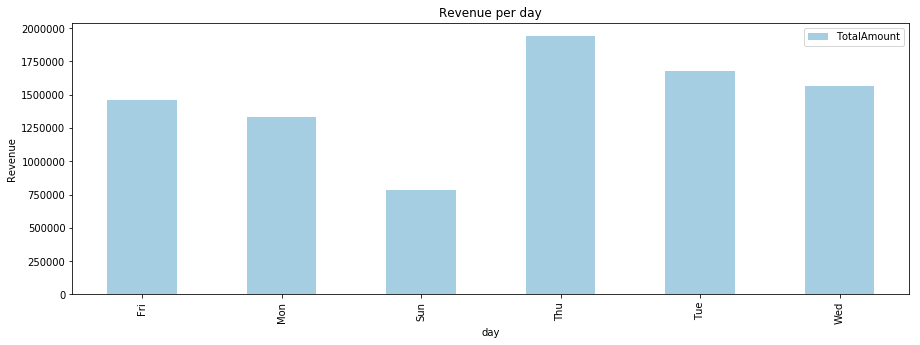

In [82]:
df = data_inv_agg.groupby(['day_of_week'], as_index=False)\
.agg({'TotalAmount': 'sum'})
ax = df.plot.bar(figsize=(15,5), x='day_of_week', y='TotalAmount', colormap='Paired' )
plt.title("Revenue per day")
plt.xlabel("day")
plt.ylabel("Revenue")
plt.show()

# Q8: How much revenue per hour does the company generate?

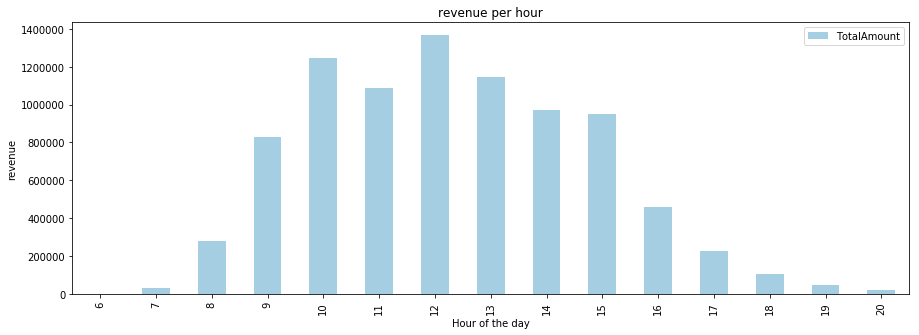

In [83]:
df = data_inv_agg.groupby(['hour'], as_index=False)\
.agg({'TotalAmount': 'sum'})
ax = df.plot.bar(figsize=(15,5), x='hour', y='TotalAmount', colormap='Paired' )
plt.title("revenue per hour")
plt.xlabel("Hour of the day")
plt.ylabel("revenue")
plt.show()

# Q9: How much revenue per country does the company generate?

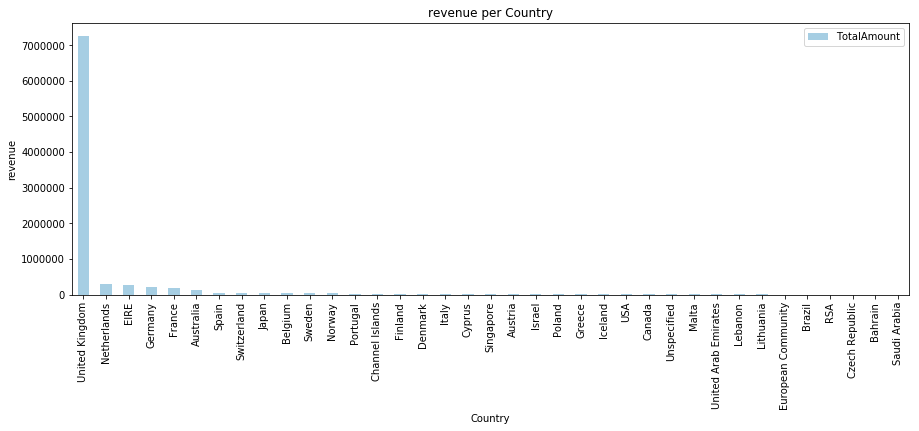

In [84]:
df = data_inv_agg.groupby(['Country'], as_index=False)\
.agg({'TotalAmount': 'sum'})
ax = (df.sort_values(by=['TotalAmount'], ascending=False)).plot.bar(figsize=(15,5), x='Country', y='TotalAmount', colormap='Paired' )
plt.title("revenue per Country")
plt.xlabel("Country")
plt.ylabel("revenue")
plt.show()

### Percentage of the total amounts

In [85]:
df = data_inv_agg.groupby(['Country'], as_index=False)\
.agg({'TotalAmount': 'sum'})
(df.sort_values(by=['TotalAmount'], ascending=False)['TotalAmount']/data['TotalAmount'].sum() * 100)[:10]

35    82.933534
23     3.240351
10     2.936818
14     2.346403
13     2.098965
0      1.577106
30     0.636054
32     0.598580
19     0.427076
3      0.421494
Name: TotalAmount, dtype: float64

### Excluding UK

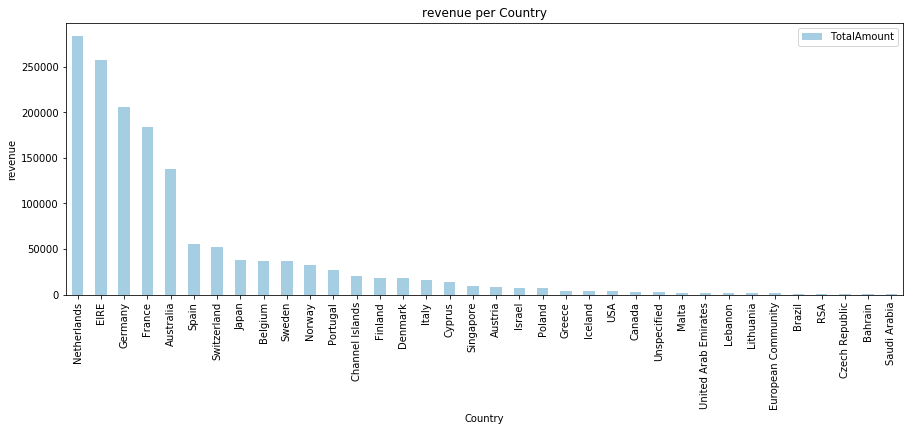

In [86]:
df = data_inv_agg.groupby(['Country'], as_index=False)\
.agg({'TotalAmount': 'sum'})

df.drop(df[df.Country == "United Kingdom"].index, inplace=True)

ax = (df.sort_values(by=['TotalAmount'], ascending=False)).plot.bar(figsize=(15,5), x='Country', y='TotalAmount', colormap='Paired' )
plt.title("revenue per Country")
plt.xlabel("Country")
plt.ylabel("revenue")
plt.show()

In [87]:
UK_excluded = data[data.Country != "United Kingdom"]
(df.sort_values(by=['TotalAmount'], ascending=False)['TotalAmount']/UK_excluded['TotalAmount'].sum() * 100)[:10]

23    18.986657
10    17.208119
14    13.748614
13    12.298765
0      9.240965
30     3.726923
32     3.507343
19     2.502425
3      2.469718
31     2.463832
Name: TotalAmount, dtype: float64

# 4. Products 

There are two columns in the dataset that represent each product: stock code and description

## Q10: How many unique products does the company has?

In [88]:
print("Number of products : {}".format(len(data['StockCode'].value_counts())))

Number of products : 3659


### A. Does each product has a unique description?

In [89]:
print("Unique description values : {}".format(len(data['Description'].value_counts())))

Unique description values : 3871


The number of products is less than the number of description, which means that description are not unique and different descriptions can belong to the same product

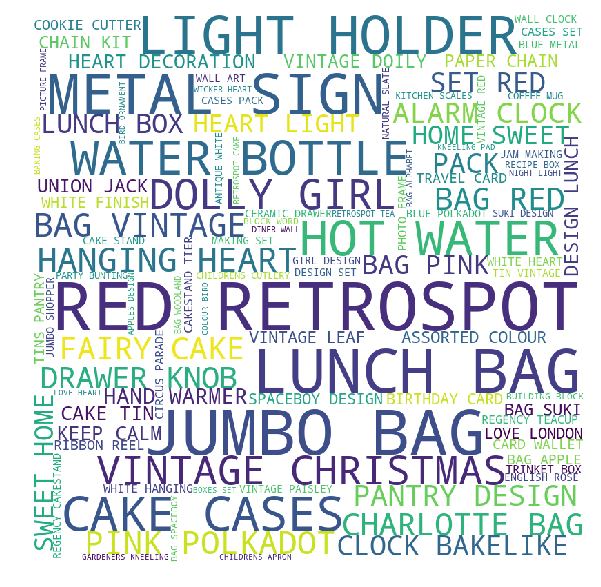

In [90]:
text = ' '.join([line for line in data['Description'] ])
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### B. Speical stock codes

At the beginning of this notebook we have removed stockcodes that represent speical transactions. I will elaborate more about this exploration. First I will get the original dataset without deleting any cancelled orders (with qnt < 0)

In [91]:
original = pd.read_csv('dataset/data.csv',encoding='iso-8859-1')
original.dropna(axis=0,subset = ['CustomerID'],inplace=True)

Let's discover more about the cancelled orders

In [92]:
#Top cancelled items
pd.DataFrame(original['Description'][original['Quantity']<0].value_counts()).head(5)

,Description
REGENCY CAKESTAND 3 TIER,181
Manual,175
POSTAGE,97
JAM MAKING SET WITH JARS,86
Discount,77


We can see that the top description of these products include Manual, Postage and Discount, which indicate that the company use some special product description to record "speical" transaction. To understand more about this, let's get the top stockcodes:

In [93]:
pd.DataFrame(original['StockCode'][original['Quantity']<0].value_counts()).head(5)

,StockCode
22423,181
M,175
POST,97
22960,86
D,77


In [94]:
#let see if there is more
codes = original[original['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
#Let match them with their description
for code in codes:
    print(code)
    print(original[original['StockCode'] == code]['Description'].unique())

POST
['POSTAGE']
D
['Discount']
C2
['CARRIAGE']
M
['Manual']
BANK CHARGES
['Bank Charges']
PADS
['PADS TO MATCH ALL CUSHIONS']
DOT
['DOTCOM POSTAGE']
CRUK
['CRUK Commission']


## Q11: What are the best-selling products?

In [114]:
top_products_codes

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,count
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2035
2035,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,1408
3443,536378,20725,LUNCH BAG RED RETROSPOT,10,2010-12-01 09:37:00,1.65,14688.0,United Kingdom,1317
4760,536386,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 09:57:00,1.65,16029.0,United Kingdom,1618
6378,536404,22383,LUNCH BAG SUKI DESIGN,10,2010-12-01 11:29:00,1.65,16218.0,United Kingdom,1083
7461,536404,20727,LUNCH BAG BLACK SKULL.,10,2010-12-01 11:29:00,1.65,16218.0,United Kingdom,1105
8566,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210.0,United Kingdom,1723
10289,536956,47566,PARTY BUNTING,5,2010-12-03 12:43:00,4.65,14210.0,United Kingdom,1396
11685,538654,22720,SET OF 3 CAKE TINS PANTRY DESIGN,6,2010-12-13 15:13:00,4.95,13089.0,United Kingdom,1159
12844,552261,23203,JUMBO BAG DOILEY PATTERNS,10,2011-05-08 11:34:00,2.08,16807.0,United Kingdom,1098


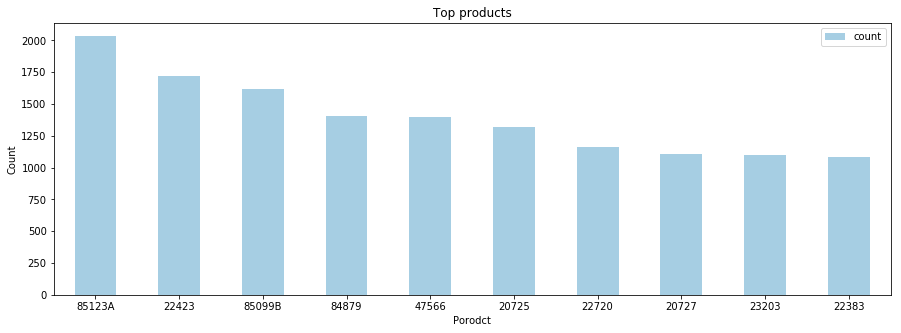

In [135]:
top_products_codes = pd.DataFrame(data['StockCode'].value_counts()[:10].reset_index().rename(columns={'StockCode':'count','index':'StockCode'}))
top_products_codes = pd.DataFrame(data.merge(top_products_codes,how='right',on='StockCode').drop_duplicates(subset='StockCode'))
top_products_codes = (top_products_codes.sort_values(by=['count'], ascending=False))[0:10]
ax = top_products_codes.plot.bar(rot=0,figsize=(15,5), x='StockCode', y='count', colormap='Paired' )
plt.title("Top products")
plt.xlabel("Porodct")
plt.ylabel("Count")
plt.show()

In [140]:
top_products_codes.iloc[0:5,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,count
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2035
8566,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210.0,United Kingdom,1723
4760,536386,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 09:57:00,1.65,16029.0,United Kingdom,1618
2035,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,1408
10289,536956,47566,PARTY BUNTING,5,2010-12-03 12:43:00,4.65,14210.0,United Kingdom,1396


# 3- RFM Analysis

In [613]:
data_customers_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 0 to 4333
Data columns (total 9 columns):
CustomerID             4334 non-null float64
Quantity               4334 non-null int64
TotalAmount            4334 non-null float64
Num_of_transactions    4334 non-null int64
Country                4334 non-null object
most_day_of_week       4334 non-null object
most_day_of_month      4334 non-null int64
most_hour              4334 non-null int64
most_month             4334 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 338.6+ KB


In [614]:
data_inv_agg.head(2)

,InvoiceNo,Quantity,TotalAmount,InvoiceDate,CustomerID,Country,month,year,yearmonth,day,hour,day_of_week
0,536365,40,139.12,2010-12-01 08:26:00,17850.0,United Kingdom,12,2010,201012,1,8,Wed
1,536366,12,22.20,2010-12-01 08:28:00,17850.0,United Kingdom,12,2010,201012,1,8,Wed


Calculate the Recency, Frequency and Monetary for each customer

In [615]:
data_customers_RFM = data_inv_agg.groupby(['CustomerID'], as_index=False)\
.agg({'Quantity': 'sum', 
      'TotalAmount': 'sum', 'InvoiceNo': 'count', 
      'Country': 'first', 
      'InvoiceDate': np.max 
     })
#rename cols
data_customers_RFM.rename({'InvoiceNo': "Frequency",
                           'TotalAmount': 'Monetary', 
                           'InvoiceDate': "Last_purchaes"
                          }, axis=1, inplace=True)
#calculate recency 
#Asuumtion: current date = 10/12/2011
import datetime
x = datetime.datetime(2011, 12, 10)
data_customers_RFM['Recency'] =  x - pd.to_datetime(data_customers_RFM['Last_purchaes'])
data_customers_RFM['Recency'] = data_customers_RFM['Recency'].apply(lambda x: x.days)

In [616]:
data_customers_RFM.head()

,CustomerID,Quantity,Monetary,Frequency,Country,Last_purchaes,Recency
0,12346.0,74215,77183.60,1,United Kingdom,2011-01-18 10:01:00,325
1,12347.0,2458,4310.00,7,Iceland,2011-12-07 15:52:00,2
2,12348.0,2332,1437.24,4,Finland,2011-09-25 13:13:00,75
3,12349.0,630,1457.55,1,Italy,2011-11-21 09:51:00,18
4,12350.0,196,294.40,1,Norway,2011-02-02 16:01:00,310


Print some randome samples 

In [617]:
data_customers_RFM[data_customers_RFM['CustomerID'] == 12413.0]

,CustomerID,Quantity,Monetary,Frequency,Country,Last_purchaes,Recency
53,12413.0,282,686.1,3,France,2011-10-04 09:00:00,66


In [631]:
data_inv_agg[data_inv_agg['CustomerID'] == 12413.0]

,InvoiceNo,Quantity,TotalAmount,InvoiceDate,CustomerID,Country,month,year,yearmonth,day,hour,day_of_week
1512,540365,177,425.25,2011-01-06 16:12:00,12413.0,France,1,2011,201101,6,16,Thu
5393,550338,25,84.65,2011-04-17 15:33:00,12413.0,France,4,2011,201104,17,15,Sun
13183,569402,80,176.20,2011-10-04 09:00:00,12413.0,France,10,2011,201110,4,9,Tue


Plot RFM values distributions

C:\Users\raghe\Anaconda2\envs\python3.7\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\raghe\Anaconda2\envs\python3.7\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\raghe\Anaconda2\envs\python3.7\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

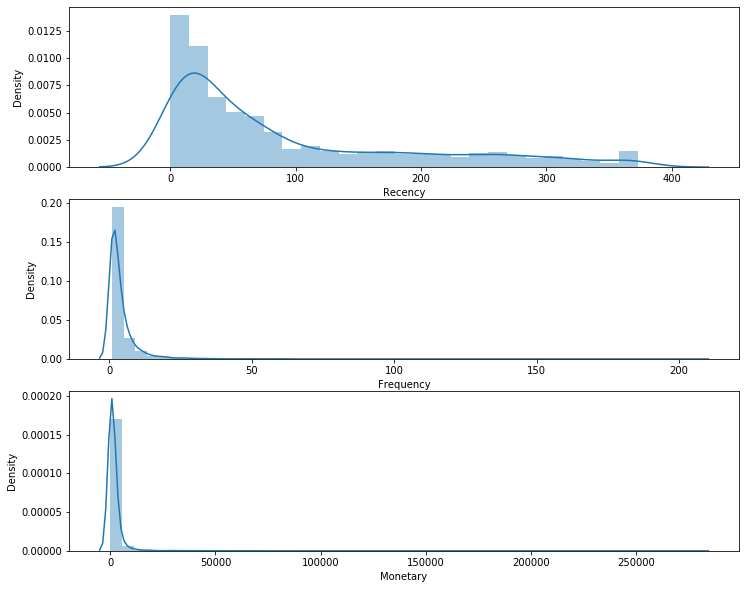

In [619]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_customers_RFM['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_customers_RFM['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_customers_RFM['Monetary'])
# Show the plot
plt.show()

In [738]:
rfm = data_customers_RFM[['CustomerID','Recency', 'Frequency', 'Monetary']]

In [739]:
len(rfm)

4334

### Remove outliers

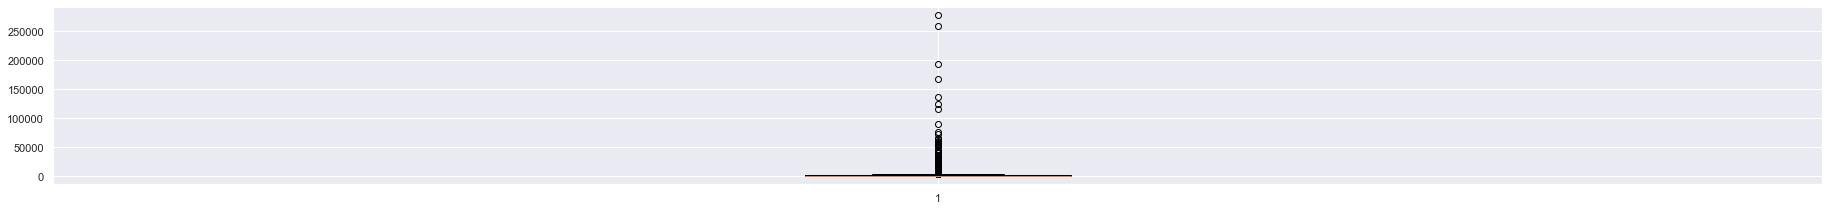

In [740]:
# outlier treatment for Amount
plt.boxplot(rfm.Monetary)
Q1 = rfm.Monetary.quantile(0.25)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= (Q1 - 1.5*IQR)) & (rfm.Monetary <= (Q3 + 1.5*IQR))]

In [741]:
# outlier treatment for Frequency
#plt.boxplot(rfm.Frequency)
#Q1 = rfm.Frequency.quantile(0.25)
#Q3 = rfm.Frequency.quantile(0.75)
#IQR = Q3 - Q1
#rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [742]:
# outlier treatment for Recency
#plt.boxplot(rfm.Recency)
#Q1 = rfm.Recency.quantile(0.25)
#Q3 = rfm.Recency.quantile(0.75)
#IQR = Q3 - Q1
#rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

### RFM quartiles


In [743]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 14.0, 0.4: 33.0, 0.6: 72.0, 0.8: 182.0},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 5.0},
 'Monetary': {0.2: 244.8,
  0.4: 473.8099999999999,
  0.6: 901.2099999999998,
  0.8: 1931.4199999999994}}

#### Scoring:

In [744]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 

In [745]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))
#combine the score
rfm['RFM_Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)/3


In [746]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
1,12347.0,2,7,4310.00,5,5,5,555,5.000000
2,12348.0,75,4,1437.24,2,4,4,244,3.333333
3,12349.0,18,1,1457.55,4,1,4,414,3.000000
4,12350.0,310,1,294.40,1,1,2,112,1.333333
5,12352.0,36,7,1385.74,3,5,4,354,4.000000


`RFM_Score` can be the total score of a customer’s engagement or loyalty.

In [747]:
# assign labels from total score
score_labels = ['Low', 'Mid', 'High']
score_groups = pd.qcut(rfm.RFM_Score, q = 3, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
1,12347.0,2,7,4310.00,5,5,5,555,5.000000,High
2,12348.0,75,4,1437.24,2,4,4,244,3.333333,Mid
3,12349.0,18,1,1457.55,4,1,4,414,3.000000,Mid
4,12350.0,310,1,294.40,1,1,2,112,1.333333,Low
5,12352.0,36,7,1385.74,3,5,4,354,4.000000,High


In [748]:
rfm[rfm['RFM_Level'] == 'Green']

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level


In [749]:
len(rfm)

4271

C:\Users\raghe\Anaconda2\envs\python3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


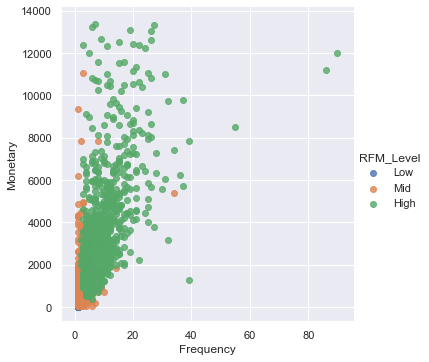

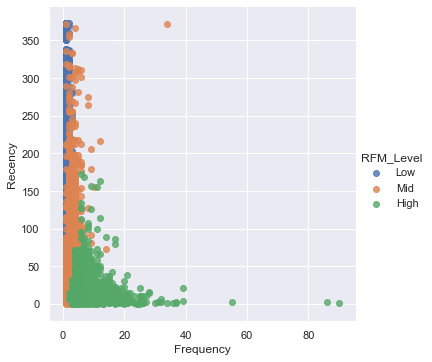

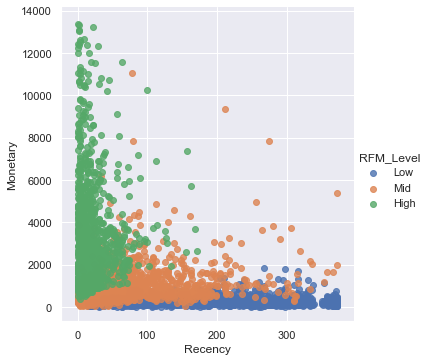

In [750]:
sns.set(rc={'figure.figsize':(31.7,3.27)})
sns.lmplot('Frequency', 'Monetary', data=rfm[['Monetary', 'Recency', 'Frequency' , 'RFM_Level']], hue='RFM_Level', fit_reg=False)
plt.show()


sns.set(rc={'figure.figsize':(31.7,3.27)})
sns.lmplot('Frequency', 'Recency', data=rfm[['Monetary', 'Recency', 'Frequency' , 'RFM_Level']], hue='RFM_Level', fit_reg=False)
plt.show()

sns.set(rc={'figure.figsize':(31.7,3.27)})
sns.lmplot('Recency', 'Monetary', data=rfm[['Monetary', 'Recency', 'Frequency' , 'RFM_Level']], hue='RFM_Level', fit_reg=False)
plt.show()


